# Introduction

In my image classifier project, I collected a dataset by scraping images from Google. To enhance the quality of the dataset, I utilized OpenCV for image preprocessing, specifically by applying face and eyes detection techniques. This allowed me to extract and isolate the facial regions from the images.

To train a model for image classification, I employed wavelet transformation to convert the images into a suitable format. This transformation helped capture important features and patterns in the images, such as eyes, nose, lips Et cetera, which would later aid in accurate classification.

To identify the most effective classifier for my dataset, I decided to experiment with multiple machine learning models. I employed the GridSearchCV technique, which systematically explores different models and their hyperparameters to find the optimal configuration.

After training and evaluating each model using GridSearchCV, I discovered that the Support Vector Machine (SVM) classifier achieved the highest accuracy of 95.4%. 

# Importing Libraries

In [ ]:
# Importing the numpy library for numerical computations
import numpy as np

# Importing libraries for data visualizations
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sn

# Importing OpenCV library for image processing tasks
import cv2 

# Importing libraries for file and directory operations
import os
import shutil

# Importing pywt module for wavelet transforms
import pywt 

# Importing libraries for machine learning for models
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.metrics import classification_report 

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

# Importing joblib for saving and loading models
import joblib

# Importing json for working with JSON data
import json

# 1️⃣ Data Preprocessing - Detecting faces and Eyes


## Read the image

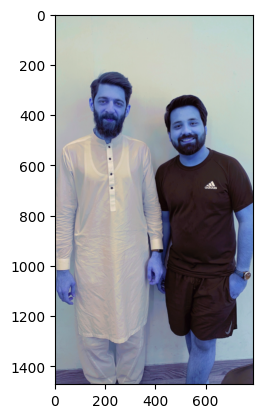

In [2]:
img_path = ('./test_images/t3.png')
img = cv2.imread(img_path)
plt.imshow(img)

## Load the face and eye cascade classifiers

In [3]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

## Method to Detect Faces and Eyes

In [4]:
def detect_and_display_faces(image_path):

    # Read the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # check if any faces are detected 
    if len(faces) == 0:
        return

    # Process each detected face
    for (x, y, w, h) in faces:
        face_img = cv2.rectangle(img, (x, y), (x+w, y+h), (225, 0, 0), 2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = face_img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)

    # Convert BGR image to RGB for displaying with matplotlib
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(rgb_img)
    plt.show()
    

#### It will perform face detection, draw rectangles around the faces and eyes, and display the image with matplotlib. If no faces are detected, the function returns without processing and displaying the image.


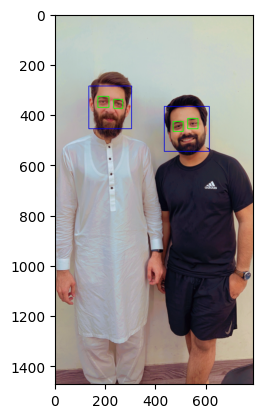

In [5]:
detect_and_display_faces(img_path)

# 2️⃣ Data Preprocessing - Cropping the facial region of the image

## Method to Crop and Display Detected Faces 

In [27]:
def crop_and_display_faces(image_path):

    # Read the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Process each detected face
    for i, (x, y, w, h) in enumerate(faces): 
        # Create a cropped image of the face region
        face_crop = img[y:y+h, x:x+w]

        # Convert the cropped face image to grayscale
        face_gray = cv2.cvtColor(face_crop, cv2.COLOR_BGR2GRAY)

        # Detect eyes in the grayscale face image
        eyes = eye_cascade.detectMultiScale(face_gray)

        # Discard the person if fewer than two eyes are detected
        if len(eyes) < 2:
            continue

        # Convert BGR image to RGB for displaying with matplotlib
        rgb_img = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

        # Display the cropped face image
        plt.imshow(rgb_img)
        plt.axis('off')
        plt.title(f"Face {i+1}")
        plt.show()

#### After detecting the eyes in the grayscale face image, we check the length of the eyes list. If the number of detected eyes is less than two, we continue to the next iteration, effectively discarding the person. Only the faces with at least two eyes will be displayed.

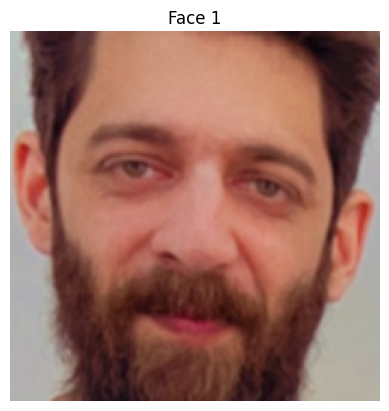

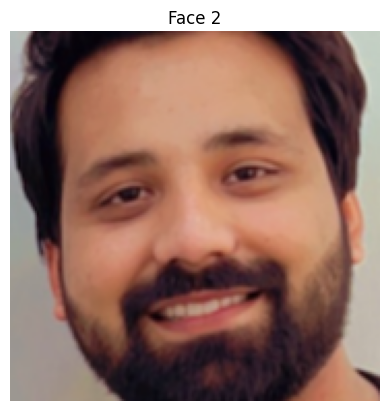

In [28]:
crop_and_display_faces(img_path)

## To Create Directories inside dataset Folder

In [433]:
# To Get individual folders exits in dataset folder

path_to_data = "./dataset"

img_dirs = [entry.path for entry in os.scandir(path_to_data) if entry.is_dir() and entry.name != "cropped"]

In [434]:
img_dirs

['./dataset/kamlish',
 './dataset/Volodymyr_Zelenskyy',
 './dataset/justin_trudeau',
 './dataset/paulo_coelho ']

Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code

In [435]:
cropped_data_folder_path = "./dataset/cropped"

# Remove the "cropped" folder if it exists

if os.path.exists(cropped_data_folder_path):
    shutil.rmtree(cropped_data_folder_path)
    
# Create the "cropped" folder  

os.makedirs(cropped_data_folder_path, exist_ok=True)

# 3️⃣ Data Preprocessing - Cropping and saving the facial region of all images in dataset

## Method to Crop and Save Detected Faces 

In [436]:
def crop_and_save_faces(image_path, dest_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    # Check if any faces are detected
    if len(faces) == 0:
        return False

    # Process each detected face
    for (x, y, w, h) in faces:
        # Extract the region of interest (ROI) containing the face
        face_roi = img[y:y+h, x:x+w]

        # Convert the face ROI to grayscale
        face_gray = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)

        # Detect eyes in the face ROI
        eyes = eye_cascade.detectMultiScale(face_gray)

        # Check if at least two eyes are detected
        if len(eyes) >= 2:
            # Save the face image
            cv2.imwrite(dest_path, face_roi)
            return True

    # No face with at least two eyes detected
    return False


In [437]:
# List to store the directories of cropped images
cropped_image_dirs = []

# Iterate over each person's image directory
for img_dir in img_dirs:
    count = 1
    person_name = os.path.basename(img_dir)
    print(person_name)

    for entry in os.scandir(img_dir):
        if entry.is_file():
            image_path = entry.path
            dest_folder = os.path.join(cropped_data_folder_path, person_name)

            # Create destination folder if it doesn't exist
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder)
                cropped_image_dirs.append(dest_folder)
                print("Generating cropped images in folder:", dest_folder)

            dest_file_name = f"{person_name}{count}.png"
            dest_path = os.path.join(dest_folder, dest_file_name)

            try:
                if crop_and_save_faces(image_path, dest_path):
                    # Face detected and saved
                    print("Cropped image saved:", dest_path)
                    count += 1
                else:
                    # No face or eyes detected, skipping the image
                    print("Skipping image without faces and eyes:", image_path)
            except Exception as e:
                # Error occurred while processing the image
                print("Error processing image:", image_path)
                print("Error details:", str(e))


kamlish
Generating cropped images in folder: ./dataset/cropped/kamlish
Cropped image saved: ./dataset/cropped/kamlish/kamlish1.png
Cropped image saved: ./dataset/cropped/kamlish/kamlish2.png
Cropped image saved: ./dataset/cropped/kamlish/kamlish3.png
Cropped image saved: ./dataset/cropped/kamlish/kamlish4.png
Cropped image saved: ./dataset/cropped/kamlish/kamlish5.png
Cropped image saved: ./dataset/cropped/kamlish/kamlish6.png
Cropped image saved: ./dataset/cropped/kamlish/kamlish7.png
Skipping image without faces and eyes: ./dataset/kamlish/Screenshot 2023-05-19 at 2.04.51 PM.png
Cropped image saved: ./dataset/cropped/kamlish/kamlish8.png
Error processing image: ./dataset/kamlish/.DS_Store
Error details: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

Cropped image saved: ./dataset/cropped/kamlish/kamlish9.png
Cropped image saved: ./dataset/cropped/kamlish/kamlis

Skipping image without faces and eyes: ./dataset/Volodymyr_Zelenskyy/image1024x768.jpeg
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy53.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy54.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy55.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy56.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy57.png
Skipping image without faces and eyes: ./dataset/Volodymyr_Zelenskyy/2022-LIBERTY-MEDAL-PRESENTATION.jpeg
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy58.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy59.png
Skipping image without faces and eyes: ./dataset/Volodymyr_Zelenskyy/fc1b6d7_5063454-01-06.jpeg
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy60.png
Cropped image saved: ./dataset

Skipping image without faces and eyes: ./dataset/Volodymyr_Zelenskyy/0x0.jpeg
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy128.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy129.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy130.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy131.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy132.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy133.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy134.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy135.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy136.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy137.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Vol

libpng warning: iCCP: known incorrect sRGB profile


Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy151.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy152.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy153.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy154.png
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy155.png
Skipping image without faces and eyes: ./dataset/Volodymyr_Zelenskyy/03190000-0aff-0242-7cdc-08da30fa3d49_w408_r1_s.jpeg
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy156.png
Skipping image without faces and eyes: ./dataset/Volodymyr_Zelenskyy/SR_23.02.21_Ukraine_feature.jpeg
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy157.png
Skipping image without faces and eyes: ./dataset/Volodymyr_Zelenskyy/Goncharuk.jpeg
Cropped image saved: ./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy158.png
justi

Skipping image without faces and eyes: ./dataset/paulo_coelho /Dream-fear-of-failure-Paulo-Coelho-Quote-1.jpeg
Skipping image without faces and eyes: ./dataset/paulo_coelho /AR-AG892_COEHLO_GR_20140813160914.jpeg
Skipping image without faces and eyes: ./dataset/paulo_coelho /com_author_.jpeg
Error processing image: ./dataset/paulo_coelho /.DS_Store
Error details: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

Cropped image saved: ./dataset/cropped/paulo_coelho /paulo_coelho 7.png
Skipping image without faces and eyes: ./dataset/paulo_coelho /Next-TwentyEight.png
Skipping image without faces and eyes: ./dataset/paulo_coelho /paulo_coelho (1).jpeg
Skipping image without faces and eyes: ./dataset/paulo_coelho /Paulo-Coelho-Quotes-On-Success.jpeg
Skipping image without faces and eyes: ./dataset/paulo_coelho /paulo-coehlo.jpeg
Skipping image without faces and eyes: ./

#### it iterates through each image directory in img_dirs, processes each image, and saves the cropped image in the corresponding person folder inside the "cropped" directory.

#### After saving images in the corresponding celebrity folder inside the "cropped" directory,  manually examined cropped folder and delete any unwanted images


# 4️⃣ Feature Engineering: Using wavelet transform as a feature for traning our model

By applying the wavelet transform to images, you can obtain a representation of the images in the frequency domain, which can capture important details and patterns, such as eyes, nose, lips Et cetera.

In [391]:
def w2d(img, mode='haar', level=1):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Perform wavelet decomposition
    coeffs = pywt.wavedec2(gray, mode, level=level)
    
    # Set the approximation coefficients to zero
    coeffs_H = [np.zeros_like(coeff) if i == 0 else coeff for i, coeff in enumerate(coeffs)]
    
    # Reconstruct image from modified coefficients
    reconstructed = pywt.waverec2(coeffs_H, mode)
    
    # Scale the reconstructed image to the range [0, 255]
    scaled = np.uint8(reconstructed)
    
    return scaled

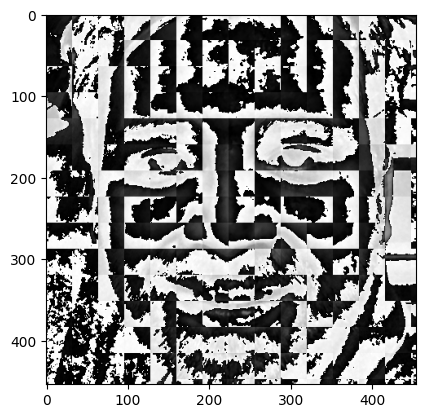

In [392]:
image_path = "./dataset/cropped/kamlish/kamlish3.png"
img = cv2.imread(image_path)
im_har = w2d(img,'db1',5)
plt.imshow(im_har, cmap='gray')

## Creating Person Files Name Dictionary

In [511]:
person_file_names_dict = {}

# Iterate over each cropped image directory
for img_dir in cropped_image_dirs:
    
    # Extract the person name from the directory path
    person_name = os.path.basename(img_dir)

    # Get the list of file paths in the directory
    file_list = [entry.path for entry in os.scandir(img_dir) if entry.is_file()]

    # Assign the file list to the person name in the dictionary
    person_file_names_dict[person_name] = file_list

# Print the resulting dictionary
person_file_names_dict


{'kamlish': ['./dataset/cropped/kamlish/kamlish12.png',
  './dataset/cropped/kamlish/kamlish11.png',
  './dataset/cropped/kamlish/kamlish3.png',
  './dataset/cropped/kamlish/kamlish10.png',
  './dataset/cropped/kamlish/.DS_Store',
  './dataset/cropped/kamlish/kamlish29.png',
  './dataset/cropped/kamlish/kamlish15.png',
  './dataset/cropped/kamlish/kamlish17.png',
  './dataset/cropped/kamlish/kamlish5.png',
  './dataset/cropped/kamlish/kamlish16.png',
  './dataset/cropped/kamlish/kamlish8.png',
  './dataset/cropped/kamlish/kamlish26.png',
  './dataset/cropped/kamlish/kamlish25.png',
  './dataset/cropped/kamlish/kamlish21.png',
  './dataset/cropped/kamlish/kamlish20.png',
  './dataset/cropped/kamlish/kamlish22.png'],
 'Volodymyr_Zelenskyy': ['./dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy144.png',
  './dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy95.png',
  './dataset/cropped/Volodymyr_Zelenskyy/Volodymyr_Zelenskyy151.png',
  './dataset/cropped/Volodymyr_Zelenskyy/Vo

#### The person_file_names_dict dictionary keeps track of the generated file names for each person images after manually delete any unwanted images.


## Creating Person Class Dictionary

In [512]:
# Initialize a dictionary comprehension to create the class_dict
# The comprehension iterates over the enumerated keys (person names) in person_file_names_dict
# The enumerated values serve as the counts, and the keys serve as the person names
# Each person name is mapped to its respective count in the resulting dictionary

class_dict = {person_name: count for count, person_name in enumerate(person_file_names_dict.keys())}

# Print the resulting class dictionary
class_dict



{'kamlish': 0,
 'Volodymyr_Zelenskyy': 1,
 'justin_trudeau': 2,
 'paulo_coelho ': 3}

### To prepare the data for model training, we will use the images in the cropped folder. These images will be used along with their corresponding wavelet transformed images. We will create two lists: X and y.

In [513]:
X, y = [], []

# Iterate over each person's training files
for person_name, training_files in person_file_names_dict.items():
    for training_image in training_files:
        
        # Check if the file ends with '.png'
        if not training_image.endswith('.png'):
            continue

        # Read the image
        img = cv2.imread(training_image)

        # Scale down the raw image to (32, 32)
        scalled_raw_img = cv2.resize(img, (32, 32))

        # Apply wavelet transform on the image ('db1' wavelet, level 5)
        img_har = w2d(img, 'db1', 5)

        # Scale down the wavelet transformed image to (32, 32)
        scalled_img_har = cv2.resize(img_har, (32, 32))

        # Flatten and stack the raw image and wavelet transformed image
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1), scalled_img_har.reshape(32*32, 1)))

        # Append the combined image feature vector to X
        X.append(combined_img)

        # Append the corresponding class label to y
        y.append(class_dict[person_name])


In [514]:
len(X)

176

In [515]:
len(X[0])

4096

In [516]:
y[100]

2

converting the list X into a NumPy array and reshaping it.

In [558]:
X = np.array(X).reshape(len(X),4096).astype(float)

In [559]:
X.shape

(176, 4096)

# 5️⃣ Training Model

## Train Test Split


The train-test split is a technique used in machine learning to evaluate the performance of a model on unseen data. It involves splitting the available dataset into two separate sets: the training set and the testing set

In [560]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

## Pipeline 

Improves code maintainability, reproducibility, efficiency, and deployment readiness in machine learning workflows.

In [561]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'linear', C=10))])
pipe.fit(X_train,y_train)
pipe.score(X_test, y_test)

0.9545454545454546

In [562]:
len(X_test)

44

## Classification Report

By using the classification report, we gain a comprehensive understanding of the model's performance across different classes, enabling us to assess its strengths, weaknesses, and overall effectiveness.

In [563]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.88      0.93        16
           2       0.89      1.00      0.94        16
           3       1.00      1.00      1.00         8

    accuracy                           0.95        44
   macro avg       0.97      0.97      0.97        44
weighted avg       0.96      0.95      0.95        44



The given report presents the performance metrics of a classification model. The model has been evaluated on a dataset containing 44 instances, divided into four different classes (0, 1, 2, and 3).

#### Precision: 
Precision measures the proportion of correctly predicted positive instances (true positives) out of all instances predicted as positive. For class 0, the precision is 1.00, indicating that all instances predicted as class 0 were correct. For class 1, the precision is also 1.00, meaning that all instances predicted as class 1 were correct. For class 2, the precision is 0.89, indicating that 89% of the instances predicted as class 2 were correct. Similarly, for class 3, the precision is 1.00, meaning that all instances predicted as class 3 were correct.

#### Recall: 

Recall measures the proportion of correctly predicted positive instances (true positives) out of all actual positive instances. For class 0 and class 3, the recall is 1.00, indicating that all actual instances of class 0 and class 3 were correctly predicted. For class 1, the recall is 0.88, meaning that 88% of the actual instances of class 1 were correctly predicted. For class 2, the recall is 1.00, indicating that all actual instances of class 2 were correctly predicted.

#### F1-score: 

F1-score is the harmonic mean of precision and recall. It provides a balanced measure of the model's performance. For class 0 and class 3, the F1-score is 1.00, indicating a perfect balance between precision and recall. For class 1, the F1-score is 0.93, indicating a good balance. For class 2, the F1-score is 0.94, indicating a relatively high performance.

#### Support: 

Support indicates the number of instances belonging to each class in the dataset. There are 4 instances of class 0, 16 instances of class 1 and 2, and 8 instances of class 3.

#### Accuracy: 

Accuracy measures the overall correctness of the model's predictions. In this case, the accuracy is 0.95, meaning that the model correctly predicted the class labels for 95% of the instances in the dataset.

#### Macro average: 

The macro average calculates the average performance across all classes, giving equal weight to each class. The macro average precision, recall, and F1-score are all 0.97, indicating high overall performance.

#### Weighted average: 

The weighted average calculates the average performance across all classes, taking into account the support (number of instances) for each class. The weighted average precision, recall, and F1-score are 0.96, 0.95, and 0.95, respectively.

## GridSearchCV

The purpose of using GridSearchCV is to systematically search for the best combination of hyperparameters for a model.

In [579]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [580]:
scores = []  # List to store scores and parameters for each model
best_estimators = {}  # Dictionary to store the best estimators for each model
import pandas as pd

# Iterate over each model and its corresponding hyperparameter grid
for algo, mp in model_params.items():
    # Create a pipeline with StandardScaler and the model
    pipe = make_pipeline(StandardScaler(), mp['model'])
    
    # Perform grid search with cross-validation using GridSearchCV
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    
    # Store the model's scores and best parameters
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
    # Store the best estimator for the model
    best_estimators[algo] = clf.best_estimator_

# Create a DataFrame from the scores list
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df


,model,best_score,best_params
0,svm,0.947293,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.713675,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.908547,{'logisticregression__C': 1}


These results suggest that Model 0, which is based on SVM with C=1 and a linear kernel, achieved the highest score of 0.947293. Model 2, which is based on logistic regression with C=1, achieved a score of 0.908547. Model 1, which is based on random forest with 10 estimators, achieved a lower score of 0.705698. These scores represent the performance of each model based on the evaluation metric used during training or cross-validation.

In [577]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [578]:
best_estimators['svm'].score(X_test,y_test)

0.9545454545454546

In [574]:
best_estimators['random_forest'].score(X_test,y_test)

0.8409090909090909

In [575]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7954545454545454

## Choosing the Best Classifier

In [581]:
best_clf = best_estimators['svm']

## Confusion Matrix

Text(95.72222222222221, 0.5, 'Truth')

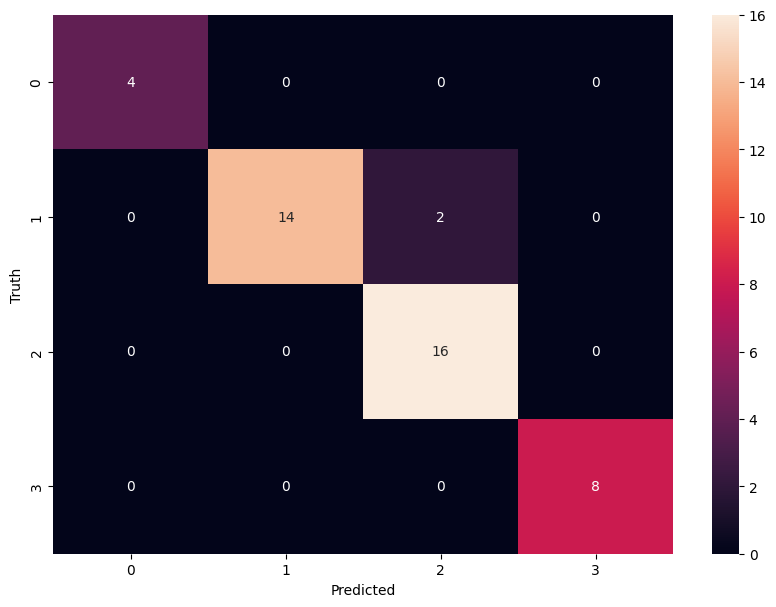

In [586]:
cm = confusion_matrix(y_test, best_clf.predict(X_test))

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot =True)
plt.xlabel("Predicted")
plt.ylabel("Truth")


## Saving Training Model

In [588]:
joblib.dump(best_clf,'ImageClassifierModel.pkl')

['ImageClassifierModel.pkl']

## Saving Class Dictionary

In [594]:
with open('class_dictionary.json','w') as f:
    f.write(json.dumps(class_dict))